# PLAN - PHASE 1

0. [x] Get the data.
0. [x] Prepare the data for exploration.
0. [x] Split the data into train and test sets.
0. [x] Explore the data.
0. [x] Do cross-validation with the data.
0. [x] Code and evaluate several models.
0. [x] Evaluate out of sample data (test set).

# PHASE 1
   ### This phase looks at the 705 subjects in the original study which includes both Abused Women and Non-Abused Women.

# ENVIRONMENT

In [1]:
# basic environment and custom scripts
import os
import acquire
import prepare
import explore
from prepare import rename_columns
from prepare import replace_nonvals
from prepare import value_counts

# numpy and pandas for dataframe building and manipulation
import pandas as pd
import numpy as np
%matplotlib inline

# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import preprocessing for scaling and splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# xgboost for feature selection
import xgboost as xgb

# Grid search
from sklearn.model_selection import GridSearchCV

# sklearn machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

#  balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier

from functools import reduce

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# ACQUISITION

In [3]:
df1 = acquire.read_data('data01.csv')
df2 = acquire.read_data('data02.csv')
df3 = acquire.read_data('data03.csv')
df4 = acquire.read_data('data04.csv')
df5 = acquire.read_data('data05.csv')
df7 = acquire.read_data('data07.csv')

In [4]:
# dfs = [df1, df2, df3]

In [5]:
df1.head()

,CASEID,INVIEWN,B1AGE,AGER,AGERR,B2EDU,HIGHSCHL,B3EMPLY1,B3EMPLY2,B3EMPLY3,...,NAWYEAR,RELAC1,LENGTHC1,C1SITUAT,PARTNERS,PABUSE,SPANISH1,INMONTH,INYEAR,INDAY
0,108395,1,18,1,1,3,0,2,9999,9999,...,99,6,1,1,1,1,2,1,1998,27
1,108397,1,30,3,2,7,1,3,9999,9999,...,99,5,2,1,1,1,2,1,1998,27
2,108399,1,27,3,1,3,0,9,9999,9999,...,99,5,5,1,1,1,2,1,1998,30
3,108443,1,19,1,1,3,0,7,9999,9999,...,99,5,2,1,1,1,2,2,1998,9
4,108444,1,18,1,1,3,0,9,9999,9999,...,99,6,2,1,1,1,2,2,1998,9


In [6]:
# Specify columns to take from dataframes 1, 2, 3, 4, 5, and 7:


one_cols = ['CASEID',
            'ABUSED',
            'SCRSTATR',
            'LENGTHC1',
            'C1SITUAT',
            'PABUSE',
             ]


two_cols = ['CASEID',
            'D3RCHILT',
           ]

three_cols = ['CASEID',
              'E13PRGNT',
              'N7PREGNT',
              'TOTSUPRT'
             ]

four_cols = ['CASEID',
             'G1NUMBER', 
             'H1JEALUS', 
             'H2LIMIT',
             'H3KNOWNG',
             'J1HIT',
             'J2THROWN',
             'J3PUSH',
             'J4SLAP',
             'J5KICK',
             'J6OBJECT',
             'J7BEAT',
             'J8CHOKE',
             'J9KNIFE',
             'J10GUN',
             'J11SEX',
             'POWER',
             'HARASS',
            ]

five_cols = ['CASEID', 
             'B1AGE',
             'AGEDISP',
             'STDETAI',
            ]

seven_cols = ['CASEID',
              'SAMESEXR',
              'N11DRUGS',
              'N12ALCHL',
              'N13SUHIM',
              'N16CHILD',
              'N17ARRST',
              'N1FRQNCY',
              'N2SVRITY',
              'N3WEAPON',
              'N4CHOKE',
              'N5SEX',
              'N6CONTRL',
              'N8JEALUS',
              'N10CPBLE',
             ]

In [7]:
# drop dataframes down to desired features
df1 = df1[one_cols]
df2 = df2[two_cols]
df3 = df3[three_cols]
df4 = df4[four_cols]
df5 = df5[five_cols]
df7 = df7[seven_cols]

In [8]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df7.shape)

(705, 6)
(705, 2)
(705, 4)
(705, 18)
(705, 4)
(705, 15)


In [9]:
dfa = df1.merge(right=df2, on='CASEID')
dfa = dfa.merge(right=df3, on='CASEID')
dfa = dfa.merge(right=df4, on='CASEID')
dfa = dfa.merge(right=df5, on='CASEID')
dfa = dfa.merge(right=df7, on='CASEID')

In [10]:
dfa.shape

(705, 44)

## dfa: this is the dataframe with the NAW (Not Abused Woman) & AW (Abused Woman) cases.

In [11]:
# look at unaltered value counts
prepare.value_counts(dfa)

CASEID

-------------------------------------------------------------

ABUSED
1    497
2    208
Name: ABUSED, dtype: int64

-------------------------------------------------------------

SCRSTATR
1      455
2      118
3      115
999     17
Name: SCRSTATR, dtype: int64

-------------------------------------------------------------

LENGTHC1
1    159
2    153
3     83
4    105
5    147
6     58
Name: LENGTHC1, dtype: int64

-------------------------------------------------------------

C1SITUAT
1    395
2     18
3     74
4     10
9    208
Name: C1SITUAT, dtype: int64

-------------------------------------------------------------

PABUSE
1    464
2     27
3      6
9    208
Name: PABUSE, dtype: int64

-------------------------------------------------------------

D3RCHILT
0      339
1      136
2      113
3       57
4       32
5        9
6        9
7        5
12       1
555      1
666      1
999      2
Name: D3RCHILT, dtype: int64

-----------------------------------------------------------

In [12]:
# change dfa to df to match conventions of prepare.py
df = dfa
# get repeated cases applied as a column
df['RECID'] = df.CASEID.apply(prepare.get_repeat_case)
#use prepare function to rename features 
prepare.rename_columns(df)

In [13]:
# ensure renaming of features worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 45 columns):
id                              705 non-null int64
abuse_past_year                 705 non-null int64
abuse_status                    705 non-null int64
length_relationship             705 non-null int64
partner_abusive                 705 non-null int64
num_abusers                     705 non-null int64
num_children                    705 non-null int64
pregnant                        705 non-null int64
beaten_while_pregnant           705 non-null int64
support_score                   705 non-null int64
guns_in_home                    705 non-null int64
jealous_past_year               705 non-null int64
limit_family_contact            705 non-null int64
location_tracking               705 non-null int64
threat_hit                      705 non-null int64
thrown_object                   705 non-null int64
push_shove                      705 non-null int64
slap                        

In [14]:
# run function to replace nonvalues and change values to conventionally boolean archetypes
prepare.replace_nonvals(df)

In [15]:
# check value counts to establish things worked
prepare.value_counts(df)

id

-------------------------------------------------------------

abuse_past_year
0    208
1    497
Name: abuse_past_year, dtype: int64

-------------------------------------------------------------

abuse_status
0    250
1    455
Name: abuse_status, dtype: int64

-------------------------------------------------------------

length_relationship
1    159
2    153
3     83
4    105
5    147
6     58
Name: length_relationship, dtype: int64

-------------------------------------------------------------

partner_abusive
0    300
1    405
Name: partner_abusive, dtype: int64

-------------------------------------------------------------

num_abusers
0    208
1    464
2     33
Name: num_abusers, dtype: int64

-------------------------------------------------------------

num_children
0      339
1      136
2      226
555      1
666      1
999      2
Name: num_children, dtype: int64

-------------------------------------------------------------

pregnant
0    631
1     74
Name: pregnant, dtype

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 45 columns):
id                              705 non-null int64
abuse_past_year                 705 non-null int64
abuse_status                    705 non-null int64
length_relationship             705 non-null int64
partner_abusive                 705 non-null int64
num_abusers                     705 non-null int64
num_children                    705 non-null int64
pregnant                        705 non-null int64
beaten_while_pregnant           705 non-null int64
support_score                   705 non-null int64
guns_in_home                    705 non-null int64
jealous_past_year               705 non-null int64
limit_family_contact            705 non-null int64
location_tracking               705 non-null int64
threat_hit                      705 non-null int64
thrown_object                   705 non-null int64
push_shove                      705 non-null int64
slap                        

# Some feature selection before going on to do EDA

### We want to eliminate the violent features, so we drop columns from the df and only select features that are not about extremely violent acts/info. Also drop the features that are 'continuous' variables. These are the harras scale, power scale, age id and the age disparity.

In [17]:
keep = list(df.drop(columns={'id','abuse_past_year', 'abuse_status','partner_abusive', 'num_abusers','beaten_while_pregnant','threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun','rape_with_threat','threat_suicide','violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever','capable_murder'}).columns)

In [18]:
keep

['length_relationship',
 'num_children',
 'pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'partner_reported_child_abuse',
 'partner_arrested',
 'controlled_ever',
 'jealous',
 'reassault']

In [19]:
keep.remove('length_relationship')
keep.remove('power_scale')
keep.remove('harass_scale')
keep.remove('id_age')
keep.remove('reassault')

In [20]:
# add the continuous variables into their own list
continuous_vars = ['length_relationship', 'power_scale', 'harass_scale', 'id_age']

In [21]:
len(keep)

16

In [22]:
df.harass_scale.value_counts()

0     156
1      90
2      66
3      63
5      60
6      55
4      43
7      38
8      29
10     26
9      21
12     16
11     13
13     13
14      9
15      3
17      3
16      1
Name: harass_scale, dtype: int64

In [23]:
df.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'reassault'],
      dtype='object')

# Split Train/Test for the t-SNE, PCA and Modeling

In [24]:
# split train and test
train_df, test_df = train_test_split(df, test_size=.15, random_state=123, stratify=df[['abuse_status']])

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# EXPLORATORY DATA ANALYSIS (EDA) OF DF (GENERAL SAMPLE INCLUDING AW & NAW)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


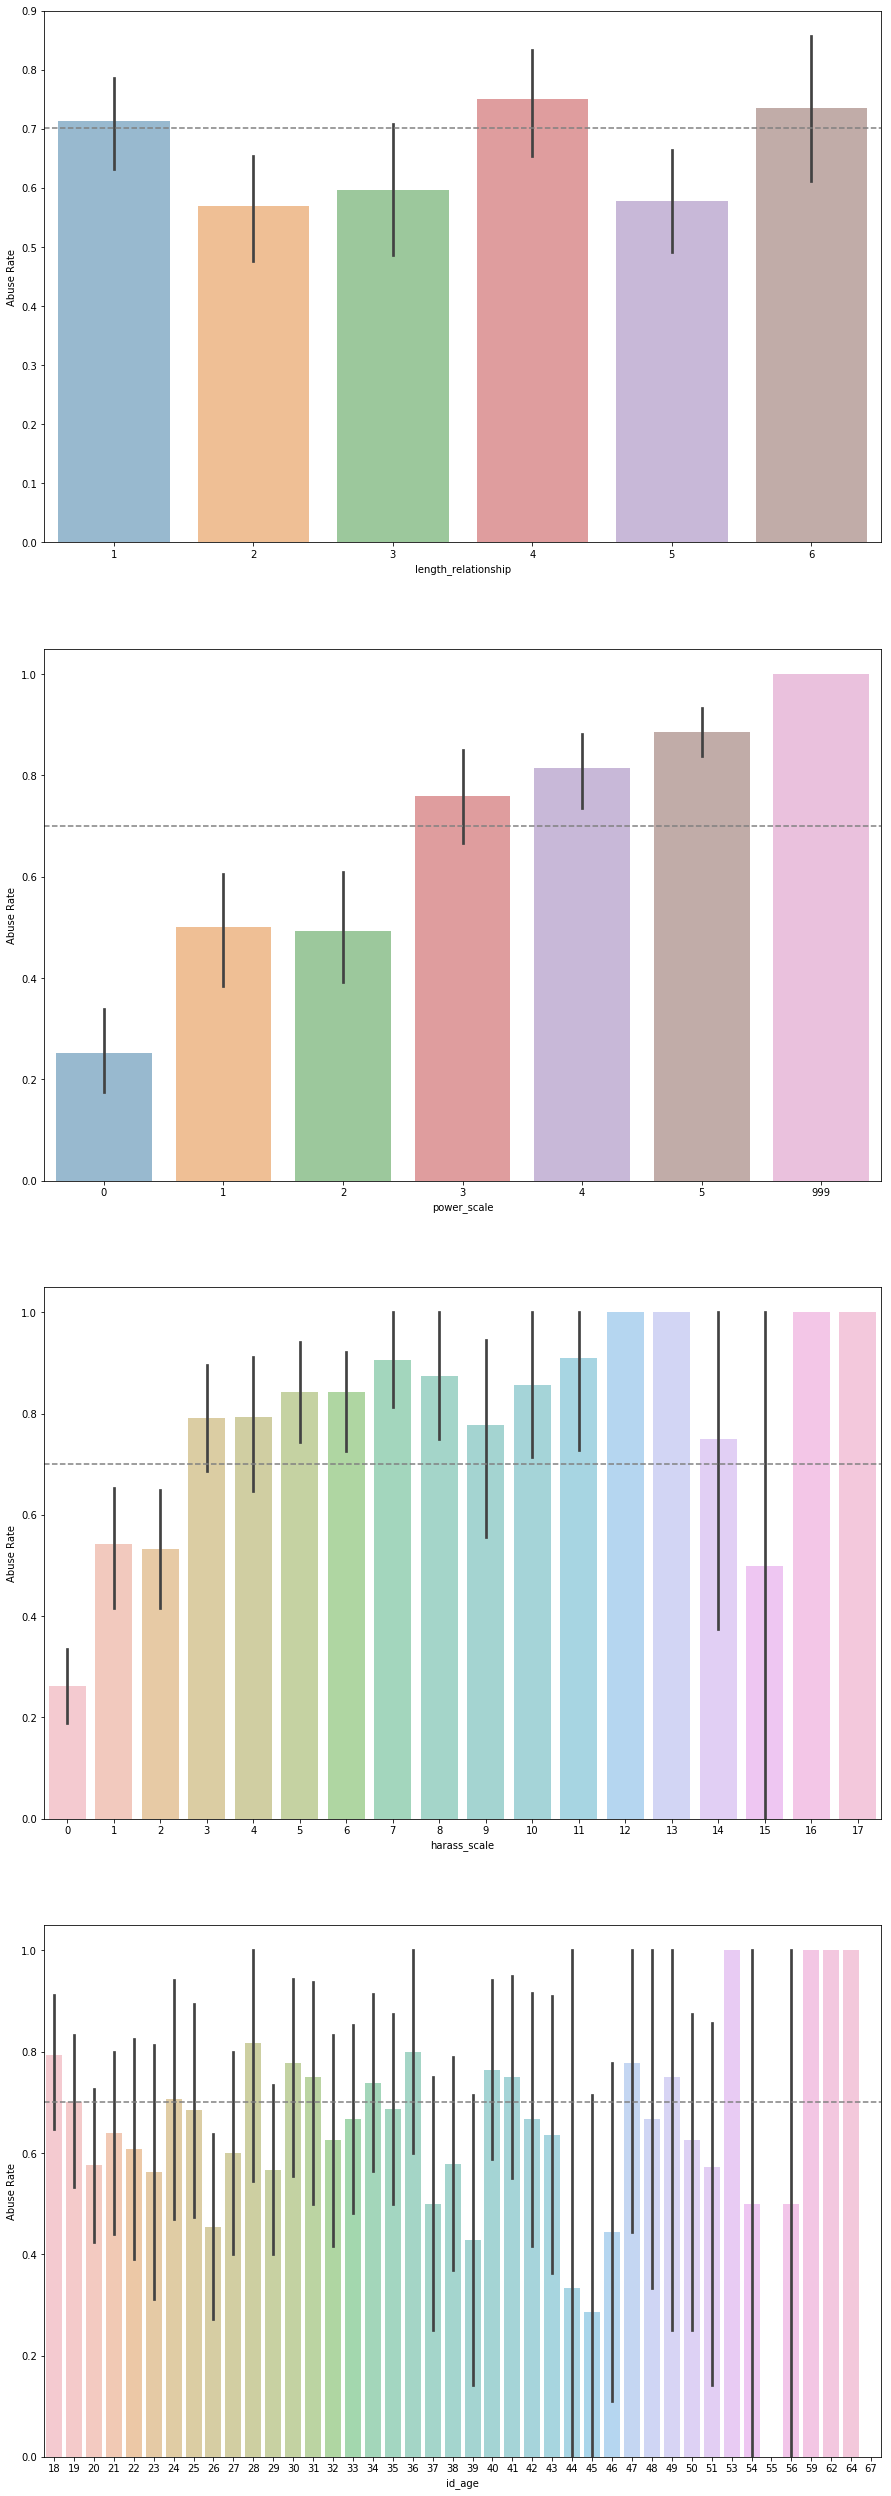

In [26]:
_, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 45))

abuse_rate = train_df.abuse_past_year.mean()

for i, feature in enumerate(continuous_vars):
    sns.barplot(feature, 'abuse_status', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Abuse Rate')
    ax[i].axhline(abuse_rate, ls='--', color='grey')

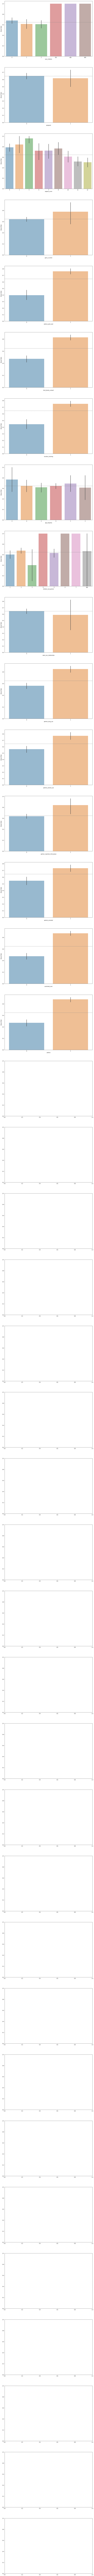

In [27]:
_, ax = plt.subplots(nrows=39, ncols=1, figsize=(15, 450))

abuse_rate = train_df.abuse_status.mean()

for i, feature in enumerate(keep):
    sns.barplot(feature, 'abuse_status', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Abuse Rate')
    ax[i].axhline(abuse_rate, ls='--', color='grey')

# Min/Max Scaling for the continuous variables.

In [28]:
scaler = MinMaxScaler()

scaler.fit(train_df[continuous_vars])

train_df[continuous_vars] = scaler.transform(train_df[continuous_vars])
test_df[continuous_vars] = scaler.transform(test_df[continuous_vars])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

# EVEN MORE EXPLORATORY DATA ANALYSIS (EDA) OF DF (GENERAL SAMPLE INCLUDING AW & NAW)

In [29]:
def plot_hist(df):
    """
    Plots the distribution of the dataframe's variables.
    """
    df.hist(figsize=(24, 20), bins=20)

In [30]:
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [31]:
prepare.get_nulls_by_row(df)

In [32]:
prepare.summarize_data(df)

HEAD
       id  abuse_past_year  abuse_status  length_relationship  \
0  108395                1             1                    1   
1  108397                1             1                    2   
2  108399                1             1                    5   
3  108443                1             1                    2   
4  108444                1             1                    2   

   partner_abusive  num_abusers  num_children  pregnant  \
0                1            1             1         0   
1                1            1             0         0   
2                1            1             2         0   
3                1            1             0         1   
4                1            1             1         0   

   beaten_while_pregnant  support_score    ...      partner_arrested  \
0                      0              0    ...                     0   
1                      0             11    ...                     1   
2                      0         

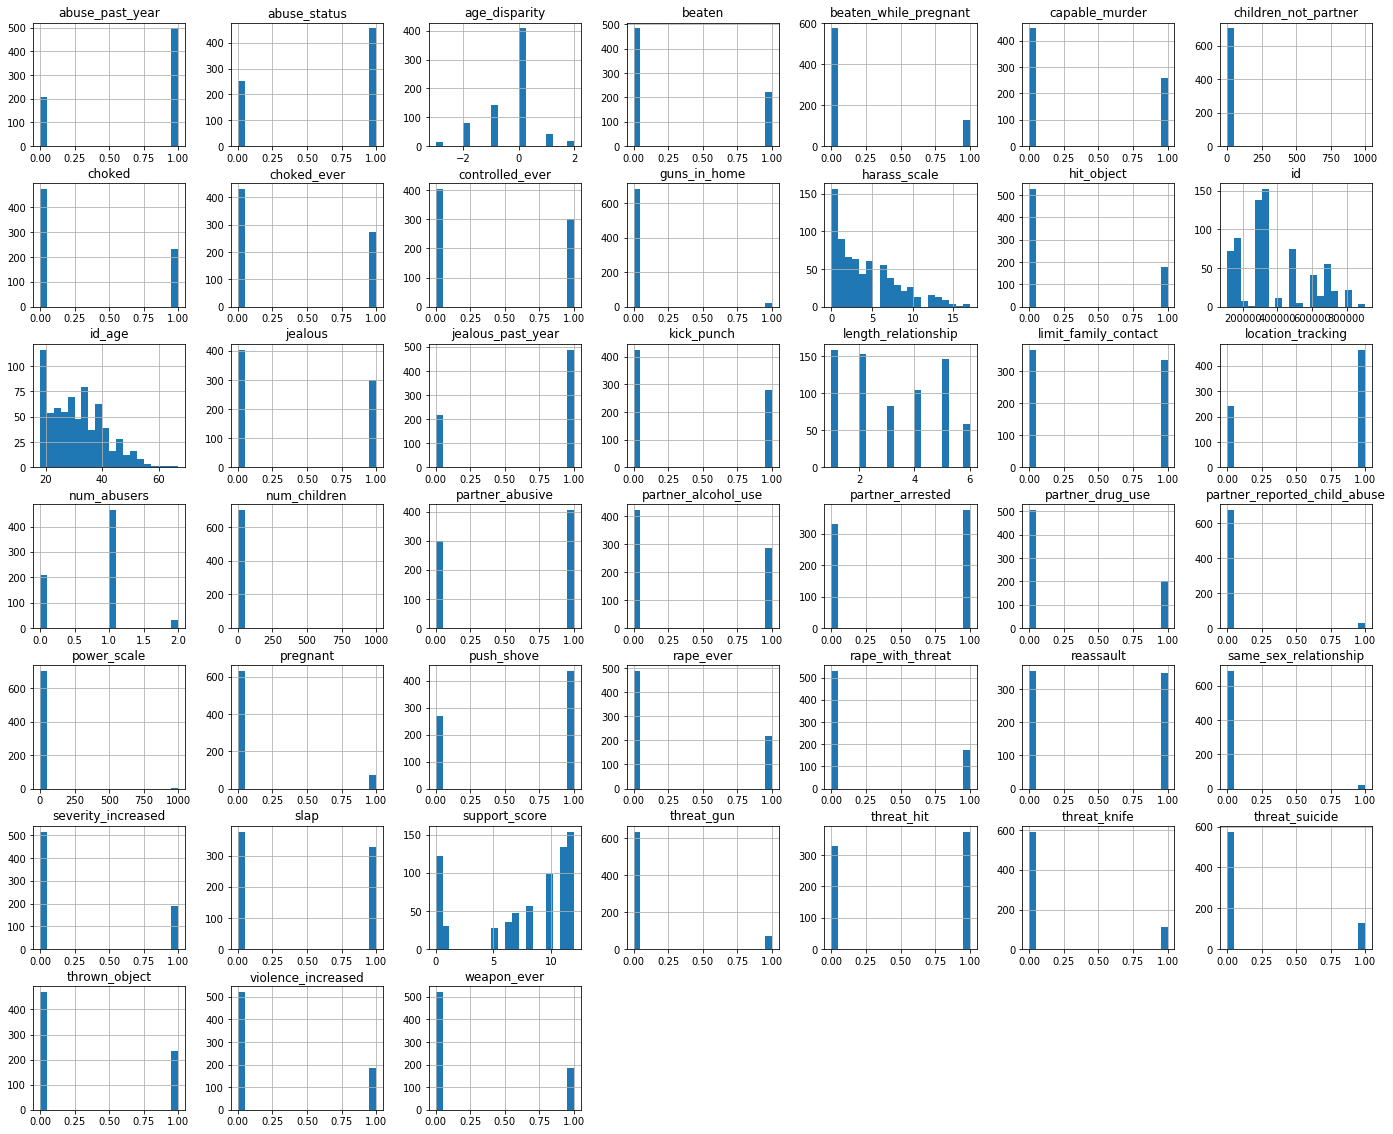

In [33]:
plot_hist(df)

In [34]:
df.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,partner_arrested,violence_increased,severity_increased,weapon_ever,choked_ever,rape_ever,controlled_ever,jealous,capable_murder,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,1,0,1,1,1,1,0,1,1,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,1,0,0,1,1,0,1,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,1,1,1,0,0,0,0,0,0,1


In [35]:
df.shape

(705, 45)

In [36]:
df.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'reassault'],
      dtype='object')

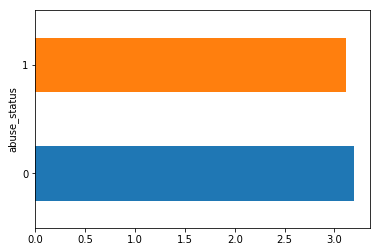

In [37]:
df.groupby('abuse_status')['length_relationship'].mean().plot.barh()

## The average length of the relationship is not so different for the AW and NAW groups.

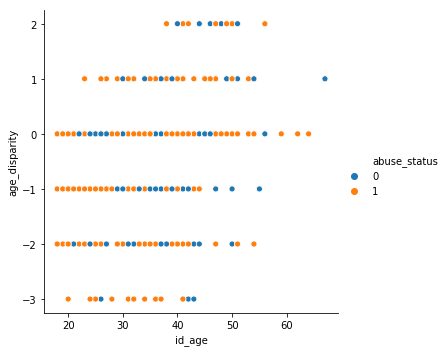

In [38]:
sns.relplot(x='id_age', y='age_disparity', data=df, hue='abuse_status')

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [39]:
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

# We want to eliminate the violent features, so we drop columns from the dfa and only select features that are not about extremely violent acts/info.

In [40]:
keep = list(dfa.drop(columns={'id','abuse_past_year', 'abuse_status','partner_abusive', 'num_abusers','beaten_while_pregnant','threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun','rape_with_threat','harass_scale','threat_suicide','violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever','capable_murder'}).columns)

In [41]:
keep

['length_relationship',
 'num_children',
 'pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'power_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'partner_reported_child_abuse',
 'partner_arrested',
 'controlled_ever',
 'jealous',
 'reassault']

# Split Train/Test for the t-SNE and PCA

In [42]:
x_columns = keep
X = dfa[x_columns]
y = dfa[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [43]:
X_train.shape

(564, 20)

# This is the t-SNE.

In [44]:
time_start = time.time()

fashion_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250, method='exact')
tsne_results = fashion_tsne.fit_transform(X_train)

print(('t-SNE done! Time elapsed: {} seconds').format(time.time()-time_start))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 564 / 564
[t-SNE] Mean sigma: 2.582078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.200869
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
t-SNE done! Time elapsed: 4.870795965194702 seconds


In [45]:
y_train

,abuse_past_year
28,1
343,0
525,1
612,1
324,0
166,0
327,0
169,1
74,1
263,1


# Set some colors for the labels.

In [46]:
# Label to color dict (manual)
label_color_dict = {1:'Abuse',0:'Not Abuse'}

# Color vector creation
cvec = [label_color_dict[label] for label in y_train.abuse_past_year]

### For t-SNE and PCA, refer to this article for some basic info: https://www.datacamp.com/community/tutorials/introduction-t-sne

# Plot t-SNE

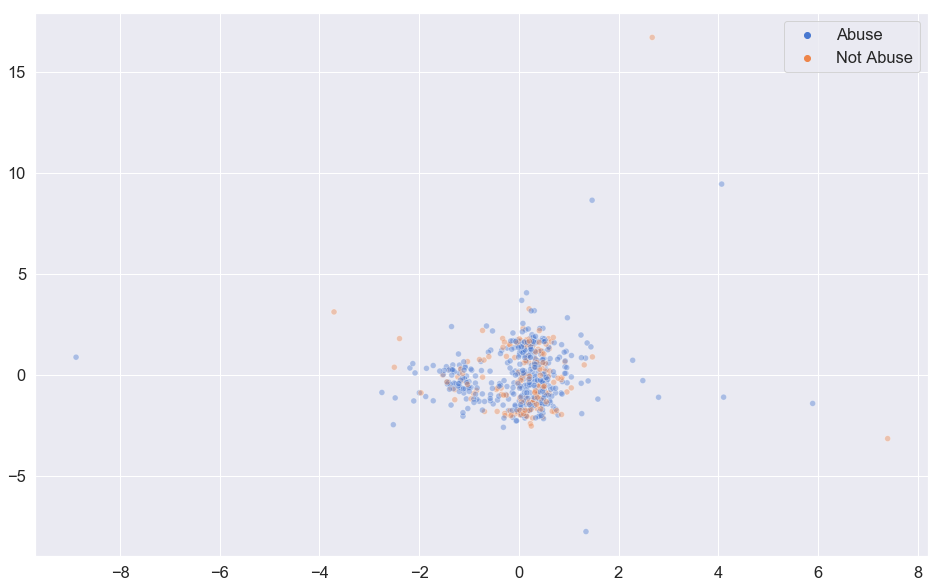

In [47]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cvec,
    data=X_train,
    legend="full",
    alpha=0.4
)

# This is the (Principal Component Analysis) PCA.

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.64957196 0.33631057 0.01057929]


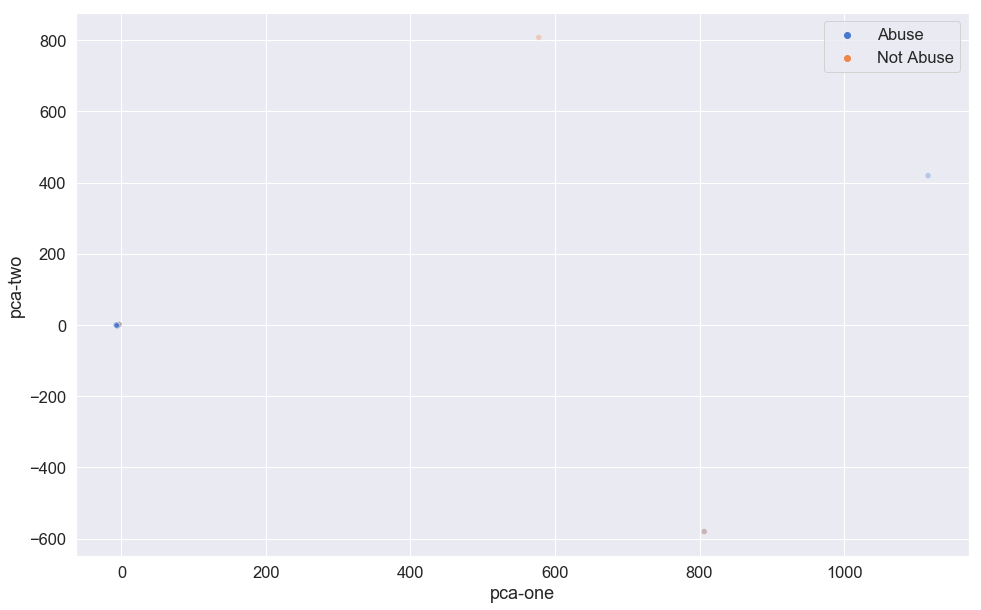

In [50]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-one'], y=pca_df['pca-two'],
    hue=cvec,
    data=X_train,
    legend="full",
    alpha=0.3
)

In [51]:
df[df.reassault == 1].shape

(350, 45)

## _So now we can see the cases where reassault happened. There are 350 cases out of 705. There were 497 cases of domestic violence._

In [52]:
df.choked.value_counts()

0    473
1    232
Name: choked, dtype: int64

In [53]:
df[df.choked == 1].shape

(232, 45)

In [54]:
df.abuse_past_year.value_counts()

1    497
0    208
Name: abuse_past_year, dtype: int64

In [55]:
df.loc[(df['abuse_past_year'] >= 1) & (df['choked'] <= 1)].shape

(497, 45)

## _232 cases involved choking or strangulation in the past year._

In [56]:
df.choked_ever.value_counts()

0    430
1    275
Name: choked_ever, dtype: int64

In [57]:
df[df.choked_ever == 1].shape

(275, 45)

In [58]:
df.loc[(df['abuse_past_year'] >= 1) & (df['choked_ever'] <= 1)].shape

(497, 45)

## _275 cases involved choking or strangulation at least once._

In [59]:
df.weapon_ever.value_counts()

0    520
1    185
Name: weapon_ever, dtype: int64

In [60]:
df[df.weapon_ever == 1].shape

(185, 45)

## _185 cases involved a weapon at least once._

In [61]:
df.violence_increased.value_counts()

0    520
1    185
Name: violence_increased, dtype: int64

In [62]:
df.loc[(df['abuse_past_year'] >= 1) & (df['violence_increased'] <= 1)].shape

(497, 45)

In [63]:
df.severity_increased.value_counts()

0    516
1    189
Name: severity_increased, dtype: int64

In [64]:
df.loc[(df['abuse_past_year'] >= 1) & (df['severity_increased'] <= 1)].shape

(497, 45)

# Modeling

# Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [66]:
X = df[keep]
y = df[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [67]:
gnb = GaussianNB()


In [68]:
gnb.fit(X_train, y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

In [69]:
y_pred = gnb.predict(X_train)

In [70]:
y_pred_proba = gnb.predict_proba(X_train)

In [71]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))

Accuracy of GNB classifier on training set: 0.91


In [72]:
print(confusion_matrix(y_train, y_pred))


[[170   7]
 [ 49 373]]


In [73]:
print(classification_report(y_train, y_pred))


             precision    recall  f1-score   support

          0       0.78      0.96      0.86       177
          1       0.98      0.88      0.93       422

avg / total       0.92      0.91      0.91       599



# This Gaussian Naive Bayes Model performed well at 91% accuracy with the following features:

In [74]:
keep

['length_relationship',
 'num_children',
 'pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'power_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'partner_reported_child_abuse',
 'partner_arrested',
 'controlled_ever',
 'jealous',
 'reassault']

## Try another GNB model with a lot fewer features. These are the top 5 features of significance according to the chi squared testing.

In [75]:
top5 = ['threat_hit',
             'controlled_ever',
             'jealous',
             'location_tracking',
             'thrown_object'
            ]

In [76]:
X = df[top5]
y = df[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [77]:
gnb = GaussianNB()

In [78]:
gnb.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

In [79]:
y_pred = gnb.predict(X_train)

In [80]:
y_pred_proba = gnb.predict_proba(X_train)

In [81]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))

print(confusion_matrix(y_train, y_pred))


print(classification_report(y_train, y_pred))

Accuracy of GNB classifier on training set: 0.93
[[174   3]
 [ 38 384]]
             precision    recall  f1-score   support

          0       0.82      0.98      0.89       177
          1       0.99      0.91      0.95       422

avg / total       0.94      0.93      0.93       599



# The GNB model performs better with the top 5 features. It has accuracy of 93%.

# Linear Support Vector Machine Model

In [82]:
from sklearn.linear_model import SGDClassifier

In [83]:
X = df[top5]
y = df[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [85]:
svm = SVC(probability = True, random_state = 123)

In [86]:
svm.fit(X_train, y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

In [87]:
y_pred = svm.predict(X_train)


In [88]:
y_pred_proba = svm.predict_proba(X_train)


In [89]:
print('Accuracy of SVM classifier on training set: {:.2f}'
      .format(svm.score(X_train, y_train)))

Accuracy of SVM classifier on training set: 0.93


In [90]:
print(confusion_matrix(y_train, y_pred))


[[174   3]
 [ 38 384]]


In [91]:
print(classification_report(y_train, y_pred))


             precision    recall  f1-score   support

          0       0.82      0.98      0.89       177
          1       0.99      0.91      0.95       422

avg / total       0.94      0.93      0.93       599



In [92]:
cross_val_score(svm, X_train, y_train, cv=3)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.94      , 0.955     , 0.89949749])

## Stochastic Gradient Descent Classifier

In [93]:
#I dunno about this stochastic gradient descent classifier...maybe its just the same as the above svm

In [94]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

In [95]:
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [96]:
my_tags = ['Not abused','Abused']

In [97]:
print('accuracy %s' % accuracy_score(y_pred, y_train))
print(classification_report(y_train, y_pred, target_names=my_tags))

accuracy 0.9315525876460768
             precision    recall  f1-score   support

 Not abused       0.82      0.98      0.89       177
     Abused       0.99      0.91      0.95       422

avg / total       0.94      0.93      0.93       599



In [98]:
cross_val_score(sgd, X_train, y_train, cv=3)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.94      , 0.955     , 0.88442211])

# Decision Tree

In [99]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

In [100]:
# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

In [101]:
grid = GridSearchCV(dtc, params, cv=3, iid=True)

In [102]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'max_features': [None, 1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [103]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [104]:
test_scores = results['mean_test_score']
test_scores

array([0.89315526, 0.80467446, 0.89482471, 0.92153589, 0.81469115,
       0.92153589, 0.93155259, 0.87479132, 0.93155259])

In [105]:
params = results['params']
params

[{'max_depth': 2, 'max_features': None},
 {'max_depth': 2, 'max_features': 1},
 {'max_depth': 2, 'max_features': 3},
 {'max_depth': 3, 'max_features': None},
 {'max_depth': 3, 'max_features': 1},
 {'max_depth': 3, 'max_features': 3},
 {'max_depth': 4, 'max_features': None},
 {'max_depth': 4, 'max_features': 1},
 {'max_depth': 4, 'max_features': 3}]

In [106]:
for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

,max_depth,max_features,score
1,2,1.0,0.804674
4,3,1.0,0.814691
7,4,1.0,0.874791
0,2,NaN,0.893155
2,2,3.0,0.894825
3,3,NaN,0.921536
5,3,3.0,0.921536
6,4,NaN,0.931553
8,4,3.0,0.931553


In [107]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [108]:
cross_val_score(dtc, X_train, y_train, cv=5)

array([0.95041322, 0.9338843 , 0.96638655, 0.87394958, 0.93277311])

In [109]:
y_pred = dtc.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 0])

In [110]:
y_pred_proba = dtc.predict_proba(X_train)
y_pred_proba

array([[0.82075472, 0.17924528],
       [0.82075472, 0.17924528],
       [0.82075472, 0.17924528],
       ...,
       [0.        , 1.        ],
       [0.02777778, 0.97222222],
       [0.        , 1.        ]])

In [111]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.93


In [112]:
confusion_matrix(y_train, y_pred)

array([[174,   3],
       [ 38, 384]])

In [113]:
sorted(y_train.abuse_past_year.unique())

[0, 1]

In [114]:
y_train.abuse_past_year.value_counts()

1    422
0    177
Name: abuse_past_year, dtype: int64

In [115]:
labels = sorted(y_train.abuse_past_year.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,174,3
1,38,384


In [116]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.98      0.89       177
          1       0.99      0.91      0.95       422

avg / total       0.94      0.93      0.93       599



In [117]:
import graphviz
from io import StringIO
from IPython.display import Image 
import pydotplus
from sklearn import preprocessing
from sklearn import tree

In [118]:
# conda install pydotplus
def plot_decision_tree(clf,feature_name,target_name):
    '''This function creates a visualization of a decision tree in png format. 
    Takes a decision tree object, feature names of the training set and a target variable for the target name.'''
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

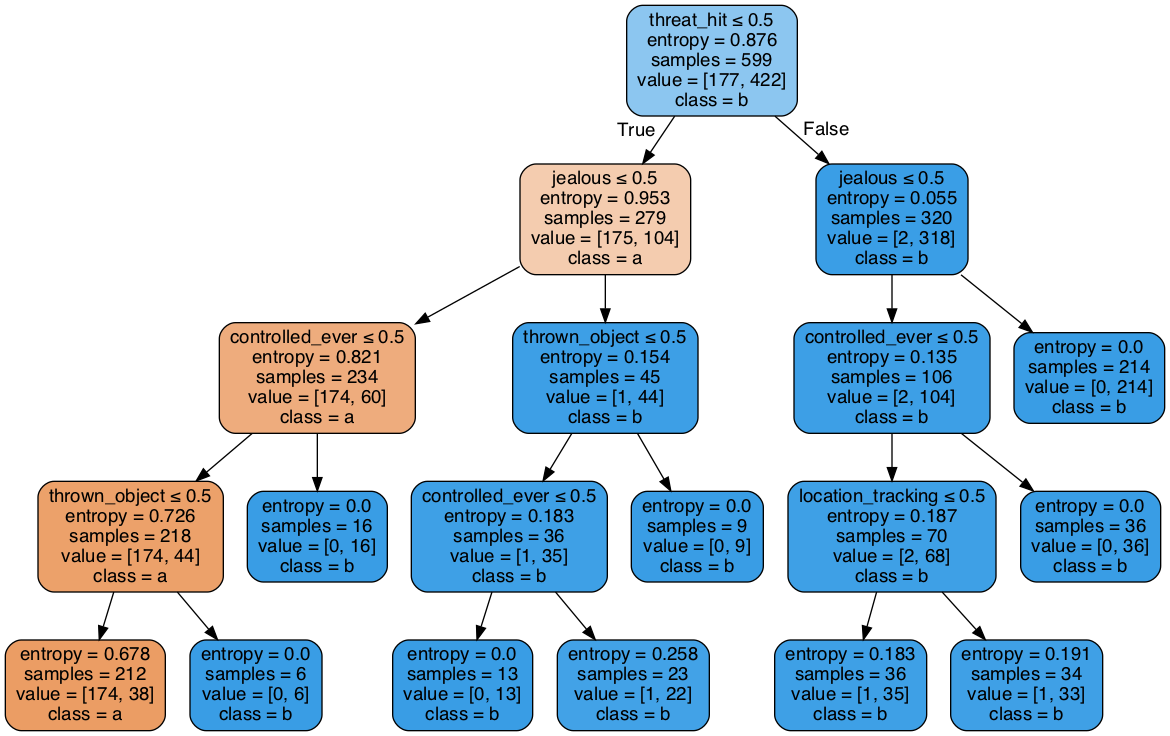

In [119]:
plot_decision_tree(dtc, X_train.columns, df.columns[1])

In [120]:
# This produces a pdf file of the decision tree!
dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=df.columns[1],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render('decision_tree_1', view=True)

'decision_tree_1.pdf'

### can maybe make it interactive too...? 
https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

# PHASE 2

## During phase 2, we look at a subset of our dataframe (705 cases/respondents) and examine the 497 AW (Abused Woman) cases where there was multiple cases of assault (re-assault).
* The target variable changes from Abuse_past_year to Reassault.
* The focus shifts to analyzing the features that predict that there will be reassault, instead of analyzing when there will be abuse or not.

# PLAN - PHASE 2

0. [x] Get the data.
0. [ ] Prepare the data for exploration.
0. [ ] Split the data into train and test sets.
0. [ ] Explore the data.
0. [ ] Do cross-validation with the data.
0. [ ] Code and evaluate several models.
0. [ ] Evaluate out of sample data (test set).

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

# Taking a peek at the other data that we have... 

# Dataframes 6 & 11 contain information on AW (Abused Woman) cases.

In [121]:
df6 = acquire.read_data('data06.csv')
# df8 = acquire.read_data('data08.csv') # NO USEFUL COLUMNS
df11 = acquire.read_data('data11.csv')
# df12 = acquire.read_data('data12.csv') # NO USEFUL COLUMNS

In [122]:
print(df6.head())
# print(df8.head())
print(df11.head())
# print(df12.head())

   CASEID  INVIEWN  ABUSED  SAMESEXR  RACER  M4GUN  M5FIRED  M6MSCRRG  \
0  108395        1       1      9999      1      2     9999         2   
1  108397        1       1      9999      9      2     9999         2   
2  108399        1       1      9999      1      2     9999         2   
3  108443        1       1      9999      1      2     9999         2   
4  108444        1       1      9999      1      2     9999         2   

   M7TIEDUP  M8PRSNT    ...     M40CNSL3  M40CNSL4  M44ADV1  M44ADV2  M44ADV3  \
0         2        2    ...         9999      9999        1     9999     9999   
1         2        1    ...         9999      9999        1     9999     9999   
2         1        1    ...         9999      9999        2        1     9999   
3         2        1    ...         9999      9999       26     9999     9999   
4         2        1    ...         9999      9999        1     9999     9999   

   M22NOINJ  M22NONED  M22PRIV  M22EMBAR  HELPTYPE  
0         1         0

In [123]:
# Specify columns to take from dataframes 6 & 11:


six_cols = ['CASEID',
            'M5FIRED',
            'M11HIGH',
            'M35SAFE',
            'M41ILLGL',
            'M42DAGRR',
            'M13TALKR',
            'M32OTHER',
            'M27HOW',
            'M30ARRES',
            'M31HOW',
            'M38ORDER',
           ]

eleven_cols = ['CASEID',
               'SEVERER',
               'TOTINCR',
               'THREATR',
               'SLAPR',
               'PUNCHR',
               'BEATR',
               'UWEAPON',
               'FORCEDR',
               'MISCARR',
               'RESTRAIN',
               'CHOKED',
               'NDRUNK',
               'RDRUNK',
               'BOTHDRUN',
               'NDRUGS',
               'RDRUGS',
               'BOTHDRUG',
              ]


In [124]:
# drop dataframes down to desired features
df6 = df6[six_cols]
df11 = df11[eleven_cols]

In [125]:
print(df6.shape)
print(df11.shape)

(497, 12)
(497, 18)


In [126]:
dfb = df6.merge(right=df11, on='CASEID')

## dfb: this is the dataframe with the AW (Abused Woman) cases 

# Import some more datasets... df9, df10, df13-15.

In [127]:
# df9 & 10 are cases of AW (Abused Woman)
df9 = acquire.read_data('data09.csv')
df10 = acquire.read_data('data10.csv')

# df 13, 14 & 15 are cases of HOMICIDE
df13 = acquire.read_data('data13.csv')
df14 = acquire.read_data('data14.csv')
df15 = acquire.read_data('data15.csv')

In [128]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


# Examine dfb in more detail. Take information from df10 and create a column that shows which cases had repeat offenses.

In [129]:
dfb['RECID'] = dfb.CASEID.apply(prepare.get_repeat_case)

In [133]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG,RECID
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,3,0,0,0,0,0,1


# Clean up the dataset for exploration...

In [134]:
dfb.columns

Index(['CASEID', 'M5FIRED', 'M11HIGH', 'M35SAFE', 'M41ILLGL', 'M42DAGRR',
       'M13TALKR', 'M32OTHER', 'M27HOW', 'M30ARRES', 'M31HOW', 'M38ORDER',
       'SEVERER', 'TOTINCR', 'THREATR', 'SLAPR', 'PUNCHR', 'BEATR', 'UWEAPON',
       'FORCEDR', 'MISCARR', 'RESTRAIN', 'CHOKED', 'NDRUNK', 'RDRUNK',
       'BOTHDRUN', 'NDRUGS', 'RDRUGS', 'BOTHDRUG', 'RECID'],
      dtype='object')

# This new column, RECID, is a boolean value that tells us whether the cases were re-assault cases or not.

# So now we can see the cases where recidivism happened. There are 350 cases out of 705. There were 497 cases of domestic violence.

In [130]:
df_re = dfb[dfb.RECID == 1]

In [131]:
df_re.shape

(350, 30)

In [132]:
df_re.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG,RECID
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,1,1,0,0,0,0,0,0,1
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,3,0,0,0,0,0,1
5,108456,9999,1,1,2,1,1,11,11,0,...,0,0,0,0,0,0,0,0,0,1
6,108460,9999,2,1,2,0,1,11,99999,3,...,0,0,0,0,0,0,0,0,0,1
